# 3.0 - Robustness analysis (KIRC)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from single_sample_gsea import ss_gsea
from matplotlib import patches

import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from src.ssGSEA.ssGSEA_related import get_GSEA_genesets
from src.utils.constants import TCGA_DATASETS

from src.stats.logrank import calculate_logrank_for_one_dataset


In [4]:
GENESETS = "Hallmarks-nostd"
GENESET_FILENAME = "h.all.v2023.1.Hs.symbols.gmt"
TCGA = "KIRC"

logrank_test = pd.read_csv(f"../data/{GENESETS}/logrank-scores-test-statistic.tsv", sep="\t", index_col=[0]).fillna(0)
logrank_test = logrank_test[TCGA].sort_values(ascending=False)

GENESETS = get_GSEA_genesets(
            pd.read_csv(f"../tcga-data/data/TCGA-{TCGA}.csv", index_col=[0]).columns,
            filename=GENESET_FILENAME, dir="../")
GENESETS = {k: list(v) for k, v in GENESETS.items()}

GENESET_NAME_SUBSET = logrank_test.head(15).index.values

In [5]:
def downsample_geneset(genes, quantile, seed:int) -> list:
    np.random.seed(seed)
    return np.random.choice(genes, size=int(len(genes)*quantile), replace=False)

def replace_genes_with_random(genes, quantile_real, all_gene_names, seed:int) -> list:
    remaining_genes = list(downsample_geneset(genes, quantile_real, seed))
    other_genes = [g for g in all_gene_names if g not in genes]
    replacement_genes = list(np.random.choice(other_genes, size=len(genes)-len(remaining_genes), replace=False))
    return remaining_genes + replacement_genes

## Downsample genes in the geneset

In [6]:
N_REPETITIONS = 100
DOWNSAMPLE_SIZES = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

np.random.seed(0)
downsample_geneset_selection = {}

for geneset in GENESET_NAME_SUBSET:
    downsample_geneset_selection[f"{geneset}_size:1.0_rep:0"] = set(GENESETS[geneset])

    for j, down_size in enumerate(DOWNSAMPLE_SIZES):
        for i in range(1, N_REPETITIONS+1):
            downsample_geneset_selection[f"{geneset}_size:{down_size}_rep:{i}"] = set(downsample_geneset(GENESETS[geneset], down_size, j*N_REPETITIONS + i))

In [7]:
DOWNSAMPLE_FILENAME = f"TCGA-{TCGA}-ssGSEA-downsample-KIRC.tsv"

if DOWNSAMPLE_FILENAME not in os.listdir("../data/downsampling/"):
    expressions = pd.read_csv(f"../tcga-data/data/TCGA-{TCGA}.csv", sep=",", index_col=[0])

    expressions = expressions.T
    expressions.index.name = "gene"

    ssGSEA_scores = ss_gsea(expressions, downsample_geneset_selection, num_cores=10)
    ssGSEA_scores = ssGSEA_scores.loc[ssGSEA_scores.index.drop_duplicates(keep=False)]

    ssGSEA_scores.reset_index().to_csv(f"../data/downsampling/{DOWNSAMPLE_FILENAME}", sep="\t", index=False)

else:
    ssGSEA_scores = pd.read_csv(f"../data/downsampling/{DOWNSAMPLE_FILENAME}", sep="\t", index_col=[0])

In [8]:
metadata = pd.read_csv(f"../tcga-data/data/raw/TCGA-{TCGA}-survival.csv", sep=",", index_col=["samples"])

common_ids = list(set(metadata.index.values).intersection(ssGSEA_scores.index.values))
metadata = metadata.loc[common_ids]
ssGSEA_scores = ssGSEA_scores.loc[common_ids]

downsample_test_statistic = calculate_logrank_for_one_dataset(metadata, ssGSEA_scores, TCGA, "test-statistic").to_dict()

In [9]:
downsample_results = {g: {str(size): [] for size in ["1.0"] + DOWNSAMPLE_SIZES} for g in GENESET_NAME_SUBSET}
for key, value in downsample_test_statistic.items():
    gs, size_rep = key.split("_size:")
    size, rep = size_rep.split("_rep:")
    downsample_results[gs][size] += [value]

Text(0, 0.5, 'Relative decrease in logrank')

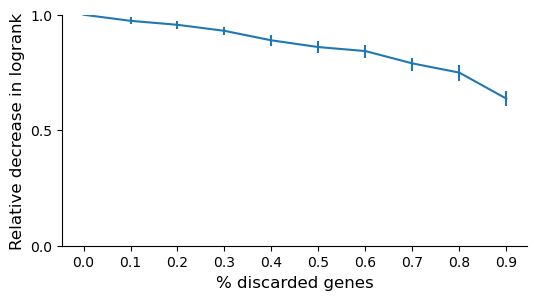

In [10]:
f, ax = plt.subplots(1,1, figsize=(6,3))

line_labels = ["1.0"] + [str(x) for x in DOWNSAMPLE_SIZES]
x_range = np.arange(len(line_labels))

y_values = {l: [] for l in line_labels}

for i, (gs, results) in enumerate(downsample_results.items()):
    start = results["1.0"][0]
    for l in line_labels:
        y_values[l] += [x/start for x in results[l]]
    
yline_mean = np.array([np.mean(y_values[l]) for l in line_labels])
yline_std = np.array([np.std(y_values[l])/np.sqrt(len(y_values[l])) for l in line_labels])

bs = [[np.mean(np.random.choice(y_values[l], size=len(y_values[l]))) for _ in range(100)] for l in line_labels]
yline_std = np.array([
    [np.abs(np.percentile(bs[i], 97.5) - yline_mean[i]) for i in range(len(bs))],
    [np.abs(np.percentile(bs[i], 02.5) - yline_mean[i]) for i in range(len(bs))]
])

ax.errorbar(x_range, yline_mean, yerr=yline_std)

for loc in ["top", "right"]:
    ax.spines[loc].set_visible(False)

ax.set_xticks(range(len(line_labels)), labels=[round(1 - float(x), 1) for x in line_labels])
ax.set_ylim(0,1)
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("% discarded genes", fontsize=12)
ax.set_ylabel("Relative decrease in logrank", fontsize=12)

## Replace discarded genes with random genes

In [11]:
N_REPETITIONS = 100
DOWNSAMPLE_SIZES = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

all_genes = list(pd.read_csv(f"../tcga-data/data/TCGA-{TCGA}.csv", sep=",", index_col=[0]).columns[2:])

np.random.seed(0)
replacement_geneset_selection = {}

for geneset in GENESET_NAME_SUBSET:
    replacement_geneset_selection[f"{geneset}_size:1.0_rep:0"] = set(GENESETS[geneset])

    for j, down_size in enumerate(DOWNSAMPLE_SIZES):
        for i in range(1, N_REPETITIONS+1):
            replacement_geneset_selection[f"{geneset}_size:{down_size}_rep:{i}"] = set(replace_genes_with_random(GENESETS[geneset], down_size, all_genes, j*N_REPETITIONS + i))

In [13]:
REPLACEMENT_FILENAME = f"TCGA-{TCGA}-ssGSEA-replacement-KIRC.tsv"

if REPLACEMENT_FILENAME not in os.listdir("../data/downsampling/"):
    expressions = pd.read_csv(f"../tcga-data/data/TCGA-{TCGA}.csv", sep=",", index_col=[0])

    expressions = expressions.T
    expressions.index.name = "gene"

    ssGSEA_scores = ss_gsea(expressions, replacement_geneset_selection, num_cores=10)
    ssGSEA_scores = ssGSEA_scores.loc[ssGSEA_scores.index.drop_duplicates(keep=False)]

    ssGSEA_scores.reset_index().to_csv(f"../data/downsampling/{REPLACEMENT_FILENAME}", sep="\t", index=False)

else:
    ssGSEA_scores = pd.read_csv(f"../data/downsampling/{REPLACEMENT_FILENAME}", sep="\t", index_col=[0])

In [14]:
metadata = pd.read_csv(f"../tcga-data/data/raw/TCGA-{TCGA}-survival.csv", sep=",", index_col=["samples"])

common_ids = list(set(metadata.index.values).intersection(ssGSEA_scores.index.values))
metadata = metadata.loc[common_ids]
ssGSEA_scores = ssGSEA_scores.loc[common_ids]

replacement_test_statistic = calculate_logrank_for_one_dataset(metadata, ssGSEA_scores, TCGA, "test-statistic").to_dict()

In [15]:
replacement_results = {g: {str(size): [] for size in ["1.0"] + DOWNSAMPLE_SIZES} for g in GENESET_NAME_SUBSET}
for key, value in replacement_test_statistic.items():
    gs, size_rep = key.split("_size:")
    size, rep = size_rep.split("_rep:")
    replacement_results[gs][size] += [value]

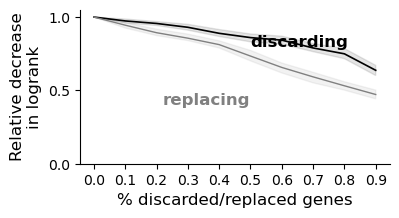

In [16]:
f, ax = plt.subplots(1,1, figsize=(4,2))

line_labels = ["1.0"] + [str(x) for x in DOWNSAMPLE_SIZES]
x_range = np.arange(len(line_labels))

# downsample
y_values = {l: [] for l in line_labels}

for i, (gs, results) in enumerate(downsample_results.items()):
    start = results["1.0"][0]
    for l in line_labels:
        y_values[l] += [x/start for x in results[l]]
    
yline_mean = np.array([np.mean(y_values[l]) for l in line_labels])
yline_std = np.array([np.std(y_values[l])/np.sqrt(len(y_values[l])) for l in line_labels])

bs = [[np.mean(np.random.choice(y_values[l], size=len(y_values[l]))) for _ in range(100)] for l in line_labels]
yline_std = [
    [(i, np.percentile(bs[i], 97.5))  for i in range(len(bs))],
    [(i, np.percentile(bs[i], 02.5)) for i in range(len(bs))]
]
ax.plot(x_range, yline_mean,label="discarding", color="k", lw=1.2, zorder=4)
ax.add_artist(patches.Polygon(yline_std[0] + yline_std[1][::-1], color="k", alpha=0.1, zorder=1))

# replacement
y_values = {l: [] for l in line_labels}

for i, (gs, results) in enumerate(replacement_results.items()):
    start = results["1.0"][0]
    for l in line_labels:
        y_values[l] += [x/start for x in results[l]]
    
yline_mean = np.array([np.mean(y_values[l]) for l in line_labels])
yline_std = np.array([np.std(y_values[l])/np.sqrt(len(y_values[l])) for l in line_labels])

bs = [[np.mean(np.random.choice(y_values[l], size=len(y_values[l]))) for _ in range(100)] for l in line_labels]
yline_std = [
    [(i, np.percentile(bs[i], 97.5)) for i in range(len(bs))],
    [(i, np.percentile(bs[i], 02.5)) for i in range(len(bs))]
]
ax.plot(x_range, yline_mean, label="replacing", color="gray", lw=1, zorder=4)
ax.add_artist(patches.Polygon(yline_std[0] + yline_std[1][::-1], color="gray", alpha=0.1, zorder=1.2))

for loc in ["top", "right"]:
    ax.spines[loc].set_visible(False)

ax.set_xticks(range(len(line_labels)), labels=[round(1 - float(x), 1) for x in line_labels])
ax.set_ylim(0,1.05)
ax.set_yticks([0, 0.5, 1])

ax.set_xlabel("% discarded/replaced genes", fontsize=12)
ax.set_ylabel("Relative decrease\nin logrank", fontsize=12)

for align, y, text, clr in zip(["left", "right"], [0.8, 0.4], ["discarding", "replacing"], ["k", "gray"]):
    ax.text(5, y, text, horizontalalignment=align, fontsize=12, weight="bold", color=clr)

## Downsampling samples

In [17]:
ssgsea = pd.read_csv(f"../data/Hallmarks/TCGA-{TCGA}-ssGSEA.tsv", sep="\t", index_col=[0])[GENESET_NAME_SUBSET]
ssgsea.head(3)

,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_PANCREAS_BETA_CELLS,HALLMARK_ADIPOGENESIS,HALLMARK_HEME_METABOLISM,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_MYC_TARGETS_V2,HALLMARK_PEROXISOME,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_PROTEIN_SECRETION,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM,HALLMARK_G2M_CHECKPOINT
samples,,,,,,,,,,,,,,,
TCGA-3Z-A93Z,1206.104463,1207.758588,1987.219441,503.128944,775.010691,2604.696928,1257.092985,-662.417779,-917.926158,1739.481370,-1029.268536,-1661.166730,-3043.246790,953.668252,-1895.678792
TCGA-6D-AA2E,3418.779422,-355.968918,2890.083640,1044.428910,2930.107037,-509.737101,2406.670128,416.177694,-337.831461,-339.535915,-1052.242767,-1016.448290,-3047.621618,2382.532345,-4069.545959
TCGA-A3-3306,1317.564092,995.243646,1865.944889,780.732468,420.544952,2692.865461,2207.775840,-1791.584746,-1219.872543,2467.869218,1303.169876,1904.560162,-621.598312,-204.076778,-83.003451


In [18]:
N_REPETITIONS = 100
DOWNSAMPLING_TO_SAMPLES = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [19]:
downsample_sample_results = {down: {gs:[] for gs in GENESET_NAME_SUBSET} for down in DOWNSAMPLING_TO_SAMPLES}

common_ids = list(set(metadata.index.values).intersection(ssgsea.index.values))

for k, down in enumerate(DOWNSAMPLING_TO_SAMPLES):
    for i in range(N_REPETITIONS):
        
        np.random.seed(i + N_REPETITIONS*k)
        ids = np.random.choice(common_ids, size=int(len(common_ids)*down), replace=False)

        test_statistic = calculate_logrank_for_one_dataset(metadata.loc[ids], ssgsea.loc[ids], TCGA, "test-statistic").to_dict()

        for key, value in test_statistic.items():
            downsample_sample_results[down][key] += [value]

downsample_sample_results = {
    key: {gs: list(np.array(v)/downsample_test_statistic[gs+"_size:1.0_rep:0"]) for gs, v in res.items()}
    for key, res in downsample_sample_results.items()
}            

In [20]:
downsample_sample_results["1.0"] = [1.0]

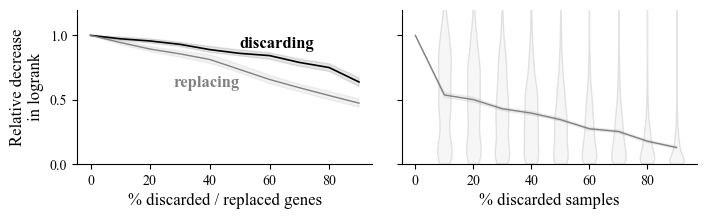

In [26]:
plt.rcParams["font.family"] = "Times New Roman"

f, ax = plt.subplots(1, 2, figsize=(8,2), sharey=True, gridspec_kw={"wspace":0.1})

line_labels = ["1.0"] + [str(x) for x in DOWNSAMPLE_SIZES]
x_range = np.arange(len(line_labels))

# downsample
y_values = {l: [] for l in line_labels}

for i, (gs, results) in enumerate(downsample_results.items()):
    start = results["1.0"][0]
    for l in line_labels:
        y_values[l] += [x/start for x in results[l]]
    
yline_mean = np.array([np.mean(y_values[l]) for l in line_labels])
yline_std = np.array([np.std(y_values[l])/np.sqrt(len(y_values[l])) for l in line_labels])

bs = [[np.mean(np.random.choice(y_values[l], size=len(y_values[l]))) for _ in range(100)] for l in line_labels]
yline_std = [
    [(i, np.percentile(bs[i], 97.5))  for i in range(len(bs))],
    [(i, np.percentile(bs[i], 02.5)) for i in range(len(bs))]
]
ax[0].plot(x_range, yline_mean,label="discarding", color="k", lw=1.2, zorder=4)
ax[0].add_artist(patches.Polygon(yline_std[0] + yline_std[1][::-1], color="k", alpha=0.1, zorder=1))

# replacement
y_values = {l: [] for l in line_labels}

for i, (gs, results) in enumerate(replacement_results.items()):
    start = results["1.0"][0]
    for l in line_labels:
        y_values[l] += [x/start for x in results[l]]
    
yline_mean = np.array([np.mean(y_values[l]) for l in line_labels])
yline_std = np.array([np.std(y_values[l])/np.sqrt(len(y_values[l])) for l in line_labels])

bs = [[np.mean(np.random.choice(y_values[l], size=len(y_values[l]))) for _ in range(100)] for l in line_labels]
yline_std = [
    [(i, np.percentile(bs[i], 97.5)) for i in range(len(bs))],
    [(i, np.percentile(bs[i], 02.5)) for i in range(len(bs))]
]
ax[0].plot(x_range, yline_mean, label="replacing", color="gray", lw=1, zorder=4)
ax[0].add_artist(patches.Polygon(yline_std[0] + yline_std[1][::-1], color="gray", alpha=0.1, zorder=1.2))

for loc in ["top", "right"]:
    for i in range(2):
        ax[i].spines[loc].set_visible(False)

ax[0].set_xticks(range(0, len(line_labels), 2), labels=[0, 20, 40, 60, 80])
ax[0].set_ylim(0,1)
ax[0].set_yticks([0, 0.5, 1])

ax[0].set_xlabel("% discarded / replaced genes", fontsize=12)
ax[0].set_ylabel("Relative decrease\nin logrank", fontsize=12)

for align, y, text, clr in zip(["left", "right"], [0.9, 0.6], ["discarding", "replacing"], ["k", "gray"]):
    ax[0].text(5, y, text, horizontalalignment=align, fontsize=12, weight="bold", color=clr)

# downsample samples

y_values = {l: [i for x in downsample_sample_results[l].values() for i in x] for l in DOWNSAMPLING_TO_SAMPLES}

yline_mean = np.array([np.mean(y_values[l]) for l in DOWNSAMPLING_TO_SAMPLES])
yline_std = np.array([np.std(y_values[l])/np.sqrt(len(y_values[l])) for l in DOWNSAMPLING_TO_SAMPLES])

bs = [[np.mean(np.random.choice(y_values[l], size=len(y_values[l]))) for _ in range(100)] for l in DOWNSAMPLING_TO_SAMPLES]
yline_std = [
    [(0, 1)] + [(i+1, np.percentile(bs[i], 97.5)) for i in range(len(bs))],
    [(0, 1)] + [(i+1, np.percentile(bs[i], 02.5)) for i in range(len(bs))]
]
ax[1].plot(np.arange(len(DOWNSAMPLING_TO_SAMPLES)+1), [1]+ list(yline_mean), label="replacing", color="gray", lw=1, zorder=4)
ax[1].add_artist(patches.Polygon(yline_std[0] + yline_std[1][::-1], color="gray", alpha=0.1, zorder=1.2))

ax[1].set_xlabel("% discarded samples", fontsize=12)
ax[1].set_xticks(range(0,9, 2), labels=[0, 20, 40, 60, 80])

vp = ax[1].violinplot(list(y_values.values()), showextrema=False)
for pc in vp['bodies']:
    pc.set_color("gray")
    pc.set_facecolor('lightgray')
    pc.set_edgecolor('gray')
    pc.set_alpha(0.2)


ax[1].set_ylim(0, 1.2)

f.savefig("../figures/downsampling-results.pdf", dpi=500, bbox_inches="tight")